In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy as dc
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import shutil
import plotly.graph_objects as go

In [2]:
main_folder = "/workspaces/Futures-First/Prediction/LSTM/data"
files = []
def list_folders(folder_path):
    # List only subdirectories (folders) in the given folder path
    return [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

def select_folder(folder_list, folder_path):
    # Show subfolders to select from
    print("\nSubfolders:")
    for i, folder in enumerate(folder_list, 1):
        print(f"{i}. {folder}")
    
    # Get the user's choice
    choice = int(input("\nSelect the number of the folder: ")) - 1
    return os.path.join(folder_path, folder_list[choice])

# List folders in the main folder and select one
subfolders = list_folders(main_folder)
first_selected_folder = select_folder(subfolders, main_folder)

# List folders in the first selected folder and select one
subfolders_in_first = list_folders(first_selected_folder)
second_selected_folder = select_folder(subfolders_in_first, first_selected_folder)

# Print all files in the second selected folder
# print(f"\nFiles in '{second_selected_folder}':")
for file_name in os.listdir(second_selected_folder):
    if os.path.isfile(os.path.join(second_selected_folder, file_name)):
        # print(file_name)
        files.append(second_selected_folder +'/' +file_name)
files.sort()
files        



Subfolders:
1. SoyBean
2. Wheat
3. Copper
4. Corn

Subfolders:
1. ZC Jul-Dec
2. ZC Mar-May
3. ZC Dec-May
4. ZC Dec-Jul
5. ZC Dec-Mar
6. ZC Jul-Sep
7. ZC Mar-Jul
8. ZC Sep-Dec
9. ZC May-Jul
10. ZC Dec-Dec


['/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2016.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2017.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2018.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2019.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2020.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2021.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2022.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2023.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2024.csv',
 '/workspaces/Futures-First/Prediction/LSTM/data/Corn/ZC Mar-May/2025.csv']

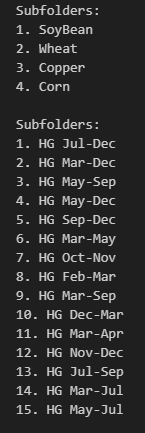
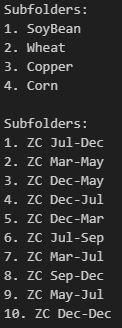

In [3]:
def delete_contents(folder_path):
    # List all items (files and folders) in the directory
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)

        # If it's a file, remove it
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")
        
        # If it's a folder, remove it and its contents
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            # print(f"Deleted folder: {item_path}")

# Provide the path to the folder you want to clean
folder_to_clean = '/workspaces/Futures-First/Prediction/LSTM/test'
delete_contents(folder_to_clean)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_one_epoch(train_loader, model, optimizer, loss_function, epoch):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index + 1}, Loss: {avg_loss_across_batches:.3f}')
            running_loss = 0.0
    print()

def validate_one_epoch(test_loader, model, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Val Loss: {avg_loss_across_batches:.3f}')
    print('***************************************************')
    print()

class TimeSeriesDataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.X)

        def __getitem__(self, i):
            return self.X[i], self.y[i]

cpu


torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.891
***************************************************

Epoch: 2

Val Loss: 0.808
***************************************************

Epoch: 3

Val Loss: 0.719
***************************************************

Epoch: 4

Val Loss: 0.639
***************************************************

Epoch: 5

Val Loss: 0.557
***************************************************

Epoch: 6

Val Loss: 0.466
***************************************************

Epoch: 7

Val Loss: 0.395
***************************************************

Epoch: 8

Val Loss: 0.324
***************************************************

Epoch: 9

Val Loss: 0.273
***************************************************

Epoch: 10

Val Loss: 0.226
***************************************************

Epoch: 11

Val Loss: 0.189
**********************************

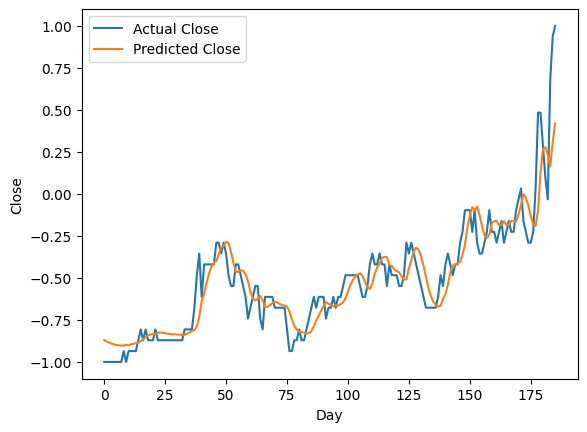

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.289
***************************************************

Epoch: 2

Val Loss: 0.249
***************************************************

Epoch: 3

Val Loss: 0.258
***************************************************

Epoch: 4

Val Loss: 0.224
***************************************************

Epoch: 5

Val Loss: 0.195
***************************************************

Epoch: 6

Val Loss: 0.203
***************************************************

Epoch: 7

Val Loss: 0.174
***************************************************

Epoch: 8

Val Loss: 0.178
***************************************************

Epoch: 9

Val Loss: 0.200
***************************************************

Epoch: 10

Val Loss: 0.143
***************************************************

Epoch: 11

Val Loss: 0.135
**********************************

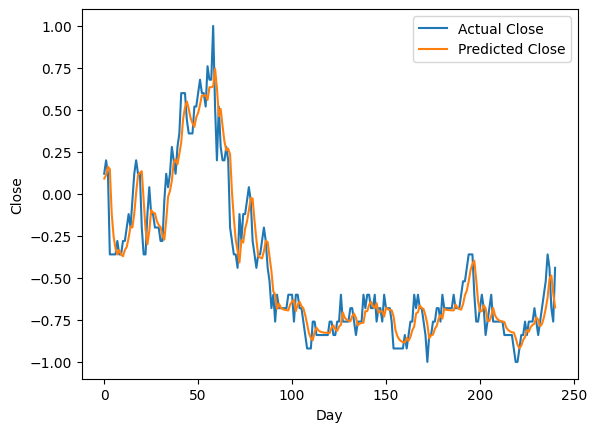

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.344
***************************************************

Epoch: 2

Val Loss: 0.330
***************************************************

Epoch: 3

Val Loss: 0.311
***************************************************

Epoch: 4

Val Loss: 0.299
***************************************************

Epoch: 5

Val Loss: 0.286
***************************************************

Epoch: 6

Val Loss: 0.273
***************************************************

Epoch: 7

Val Loss: 0.262
***************************************************

Epoch: 8

Val Loss: 0.236
***************************************************

Epoch: 9

Val Loss: 0.215
***************************************************

Epoch: 10

Val Loss: 0.187
***************************************************

Epoch: 11

Val Loss: 0.157
**********************************

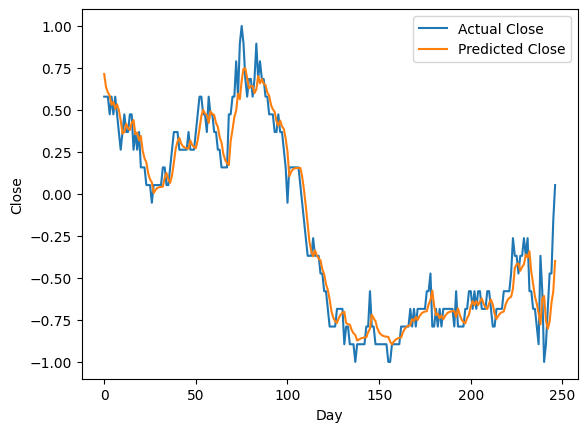

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.423
***************************************************

Epoch: 2

Val Loss: 0.383
***************************************************

Epoch: 3

Val Loss: 0.348
***************************************************

Epoch: 4

Val Loss: 0.314
***************************************************

Epoch: 5

Val Loss: 0.285
***************************************************

Epoch: 6

Val Loss: 0.260
***************************************************

Epoch: 7

Val Loss: 0.240
***************************************************

Epoch: 8

Val Loss: 0.224
***************************************************

Epoch: 9

Val Loss: 0.213
***************************************************

Epoch: 10

Val Loss: 0.203
***************************************************

Epoch: 11

Val Loss: 0.193
**********************************

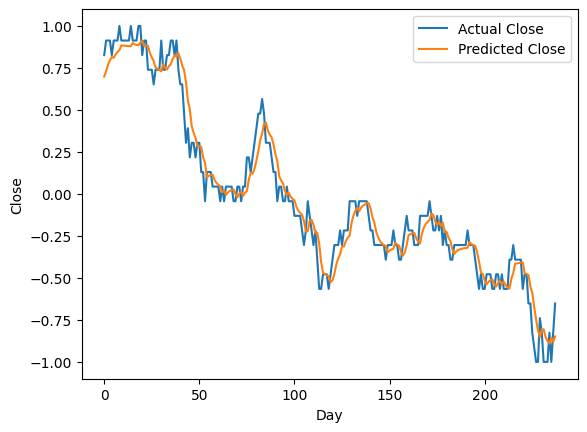

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.132
***************************************************

Epoch: 2

Val Loss: 0.129
***************************************************

Epoch: 3

Val Loss: 0.119
***************************************************

Epoch: 4

Val Loss: 0.113
***************************************************

Epoch: 5

Val Loss: 0.110
***************************************************

Epoch: 6

Val Loss: 0.115
***************************************************

Epoch: 7

Val Loss: 0.104
***************************************************

Epoch: 8

Val Loss: 0.101
***************************************************

Epoch: 9

Val Loss: 0.089
***************************************************

Epoch: 10

Val Loss: 0.079
***************************************************

Epoch: 11

Val Loss: 0.069
**********************************

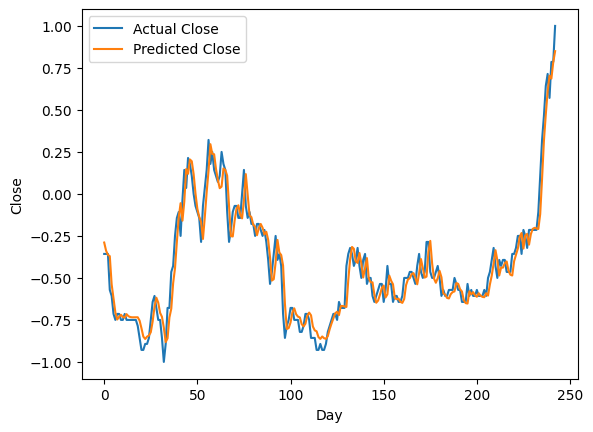

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.992
***************************************************

Epoch: 2

Val Loss: 0.917
***************************************************

Epoch: 3

Val Loss: 0.808
***************************************************

Epoch: 4

Val Loss: 0.700
***************************************************

Epoch: 5

Val Loss: 0.538
***************************************************

Epoch: 6

Val Loss: 0.383
***************************************************

Epoch: 7

Val Loss: 0.234
***************************************************

Epoch: 8

Val Loss: 0.119
***************************************************

Epoch: 9

Val Loss: 0.053
***************************************************

Epoch: 10

Val Loss: 0.028
***************************************************

Epoch: 11

Val Loss: 0.023
**********************************

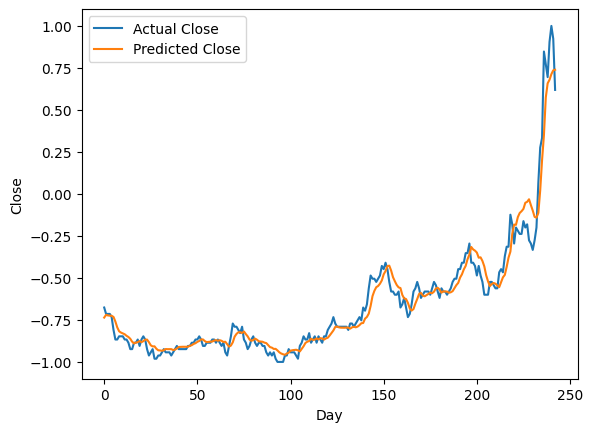

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.073
***************************************************

Epoch: 2

Val Loss: 0.052
***************************************************

Epoch: 3

Val Loss: 0.038
***************************************************

Epoch: 4

Val Loss: 0.030
***************************************************

Epoch: 5

Val Loss: 0.030
***************************************************

Epoch: 6

Val Loss: 0.028
***************************************************

Epoch: 7

Val Loss: 0.032
***************************************************

Epoch: 8

Val Loss: 0.035
***************************************************

Epoch: 9

Val Loss: 0.023
***************************************************

Epoch: 10

Val Loss: 0.023
***************************************************

Epoch: 11

Val Loss: 0.023
**********************************

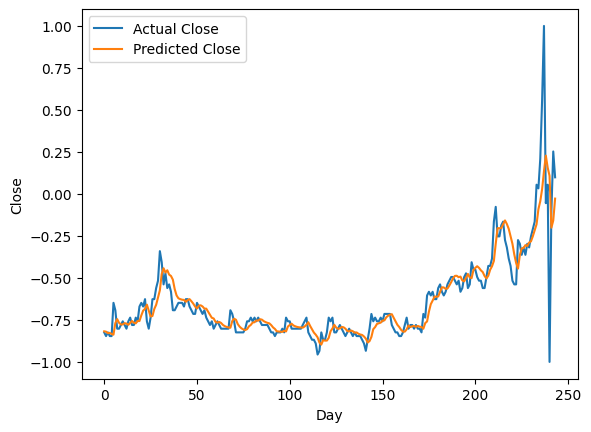

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.692
***************************************************

Epoch: 2

Val Loss: 0.619
***************************************************

Epoch: 3

Val Loss: 0.523
***************************************************

Epoch: 4

Val Loss: 0.456
***************************************************

Epoch: 5

Val Loss: 0.389
***************************************************

Epoch: 6

Val Loss: 0.335
***************************************************

Epoch: 7

Val Loss: 0.333
***************************************************

Epoch: 8

Val Loss: 0.238
***************************************************

Epoch: 9

Val Loss: 0.202
***************************************************

Epoch: 10

Val Loss: 0.171
***************************************************

Epoch: 11

Val Loss: 0.165
**********************************

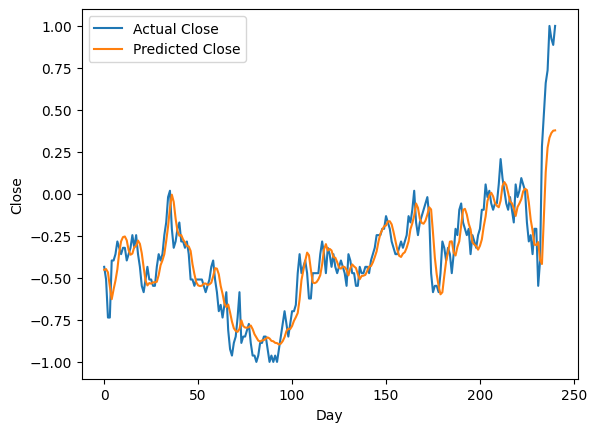

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.191
***************************************************

Epoch: 2

Val Loss: 0.178
***************************************************

Epoch: 3

Val Loss: 0.169
***************************************************

Epoch: 4

Val Loss: 0.149
***************************************************

Epoch: 5

Val Loss: 0.150
***************************************************

Epoch: 6

Val Loss: 0.132
***************************************************

Epoch: 7

Val Loss: 0.115
***************************************************

Epoch: 8

Val Loss: 0.120
***************************************************

Epoch: 9

Val Loss: 0.090
***************************************************

Epoch: 10

Val Loss: 0.074
***************************************************

Epoch: 11

Val Loss: 0.060
**********************************

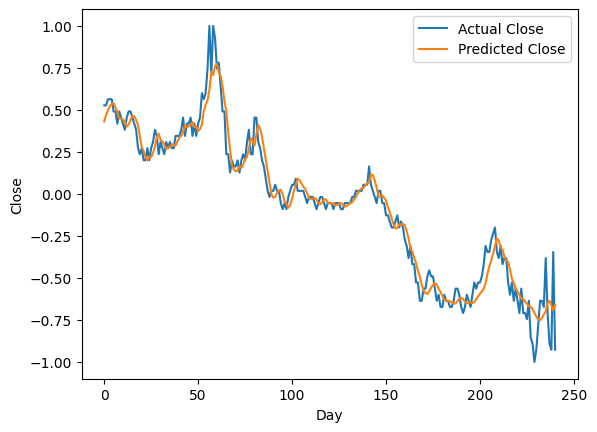

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.128
***************************************************

Epoch: 2

Val Loss: 0.111
***************************************************

Epoch: 3

Val Loss: 0.102
***************************************************

Epoch: 4

Val Loss: 0.089
***************************************************

Epoch: 5

Val Loss: 0.081
***************************************************

Epoch: 6

Val Loss: 0.076
***************************************************

Epoch: 7

Val Loss: 0.071
***************************************************

Epoch: 8

Val Loss: 0.073
***************************************************

Epoch: 9

Val Loss: 0.062
***************************************************

Epoch: 10

Val Loss: 0.058
***************************************************

Epoch: 11

Val Loss: 0.057
**********************************

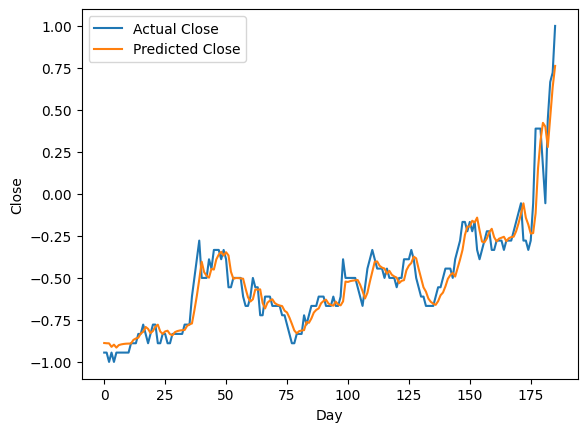

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.210
***************************************************

Epoch: 2

Val Loss: 0.200
***************************************************

Epoch: 3

Val Loss: 0.190
***************************************************

Epoch: 4

Val Loss: 0.174
***************************************************

Epoch: 5

Val Loss: 0.175
***************************************************

Epoch: 6

Val Loss: 0.159
***************************************************

Epoch: 7

Val Loss: 0.152
***************************************************

Epoch: 8

Val Loss: 0.145
***************************************************

Epoch: 9

Val Loss: 0.118
***************************************************

Epoch: 10

Val Loss: 0.166
***************************************************

Epoch: 11

Val Loss: 0.086
**********************************

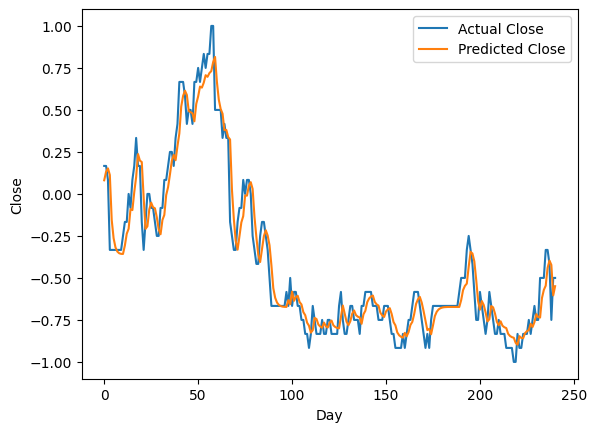

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.338
***************************************************

Epoch: 2

Val Loss: 0.321
***************************************************

Epoch: 3

Val Loss: 0.299
***************************************************

Epoch: 4

Val Loss: 0.281
***************************************************

Epoch: 5

Val Loss: 0.262
***************************************************

Epoch: 6

Val Loss: 0.242
***************************************************

Epoch: 7

Val Loss: 0.212
***************************************************

Epoch: 8

Val Loss: 0.183
***************************************************

Epoch: 9

Val Loss: 0.159
***************************************************

Epoch: 10

Val Loss: 0.119
***************************************************

Epoch: 11

Val Loss: 0.087
**********************************

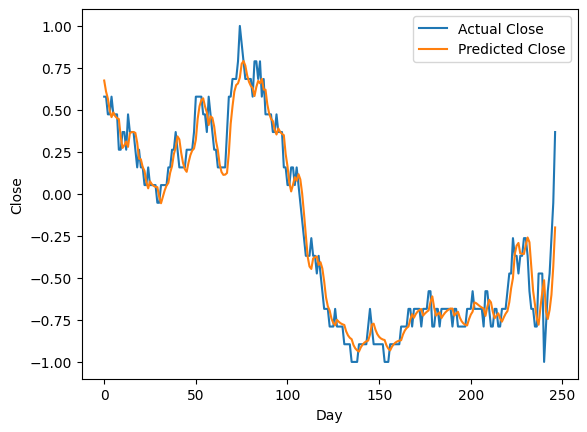

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.334
***************************************************

Epoch: 2

Val Loss: 0.315
***************************************************

Epoch: 3

Val Loss: 0.295
***************************************************

Epoch: 4

Val Loss: 0.281
***************************************************

Epoch: 5

Val Loss: 0.266
***************************************************

Epoch: 6

Val Loss: 0.253
***************************************************

Epoch: 7

Val Loss: 0.240
***************************************************

Epoch: 8

Val Loss: 0.226
***************************************************

Epoch: 9

Val Loss: 0.210
***************************************************

Epoch: 10

Val Loss: 0.193
***************************************************

Epoch: 11

Val Loss: 0.176
**********************************

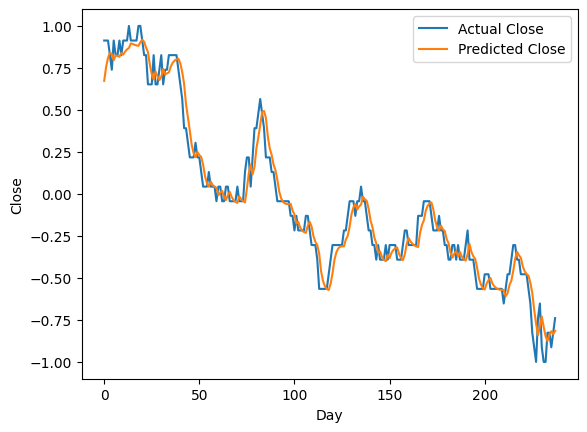

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.146
***************************************************

Epoch: 2

Val Loss: 0.128
***************************************************

Epoch: 3

Val Loss: 0.128
***************************************************

Epoch: 4

Val Loss: 0.127
***************************************************

Epoch: 5

Val Loss: 0.117
***************************************************

Epoch: 6

Val Loss: 0.126
***************************************************

Epoch: 7

Val Loss: 0.100
***************************************************

Epoch: 8

Val Loss: 0.093
***************************************************

Epoch: 9

Val Loss: 0.081
***************************************************

Epoch: 10

Val Loss: 0.069
***************************************************

Epoch: 11

Val Loss: 0.053
**********************************

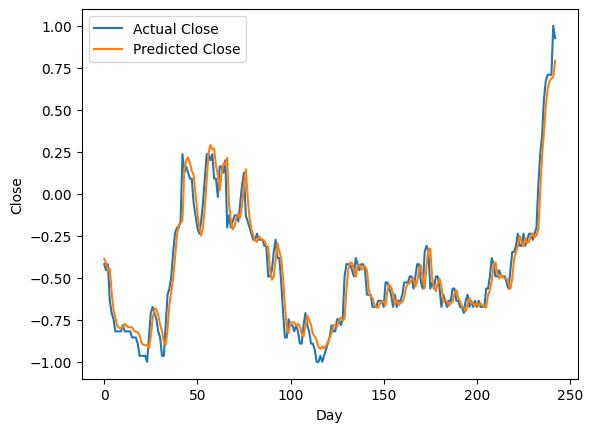

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.927
***************************************************

Epoch: 2

Val Loss: 0.804
***************************************************

Epoch: 3

Val Loss: 0.699
***************************************************

Epoch: 4

Val Loss: 0.621
***************************************************

Epoch: 5

Val Loss: 0.539
***************************************************

Epoch: 6

Val Loss: 0.485
***************************************************

Epoch: 7

Val Loss: 0.415
***************************************************

Epoch: 8

Val Loss: 0.365
***************************************************

Epoch: 9

Val Loss: 0.308
***************************************************

Epoch: 10

Val Loss: 0.291
***************************************************

Epoch: 11

Val Loss: 0.249
**********************************

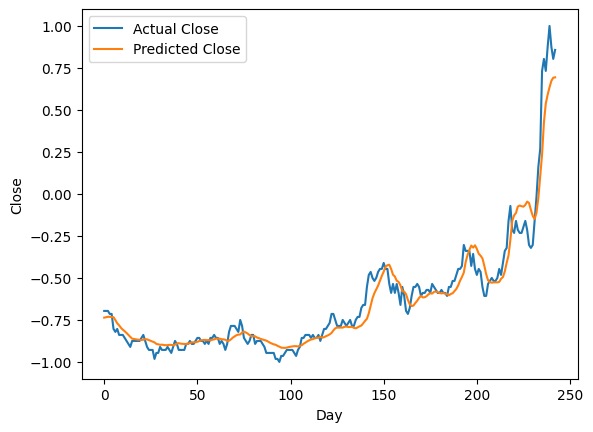

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.304
***************************************************

Epoch: 2

Val Loss: 0.268
***************************************************

Epoch: 3

Val Loss: 0.233
***************************************************

Epoch: 4

Val Loss: 0.199
***************************************************

Epoch: 5

Val Loss: 0.168
***************************************************

Epoch: 6

Val Loss: 0.138
***************************************************

Epoch: 7

Val Loss: 0.108
***************************************************

Epoch: 8

Val Loss: 0.084
***************************************************

Epoch: 9

Val Loss: 0.066
***************************************************

Epoch: 10

Val Loss: 0.058
***************************************************

Epoch: 11

Val Loss: 0.046
**********************************

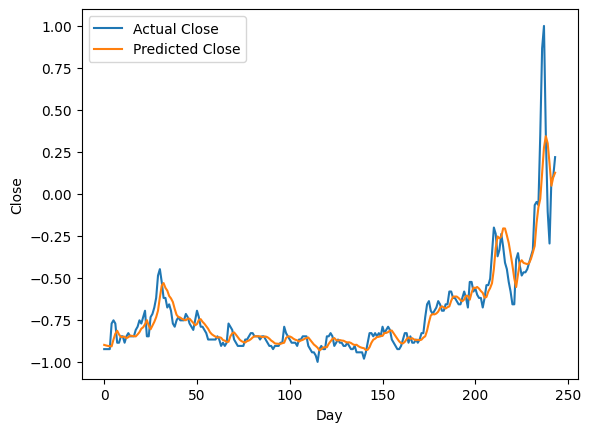

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.506
***************************************************

Epoch: 2

Val Loss: 0.434
***************************************************

Epoch: 3

Val Loss: 0.403
***************************************************

Epoch: 4

Val Loss: 0.303
***************************************************

Epoch: 5

Val Loss: 0.235
***************************************************

Epoch: 6

Val Loss: 0.164
***************************************************

Epoch: 7

Val Loss: 0.095
***************************************************

Epoch: 8

Val Loss: 0.069
***************************************************

Epoch: 9

Val Loss: 0.038
***************************************************

Epoch: 10

Val Loss: 0.034
***************************************************

Epoch: 11

Val Loss: 0.035
**********************************

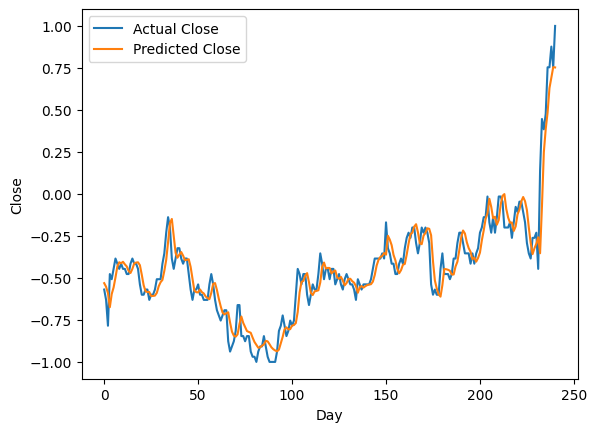

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.242
***************************************************

Epoch: 2

Val Loss: 0.211
***************************************************

Epoch: 3

Val Loss: 0.182
***************************************************

Epoch: 4

Val Loss: 0.167
***************************************************

Epoch: 5

Val Loss: 0.118
***************************************************

Epoch: 6

Val Loss: 0.098
***************************************************

Epoch: 7

Val Loss: 0.072
***************************************************

Epoch: 8

Val Loss: 0.057
***************************************************

Epoch: 9

Val Loss: 0.040
***************************************************

Epoch: 10

Val Loss: 0.032
***************************************************

Epoch: 11

Val Loss: 0.025
**********************************

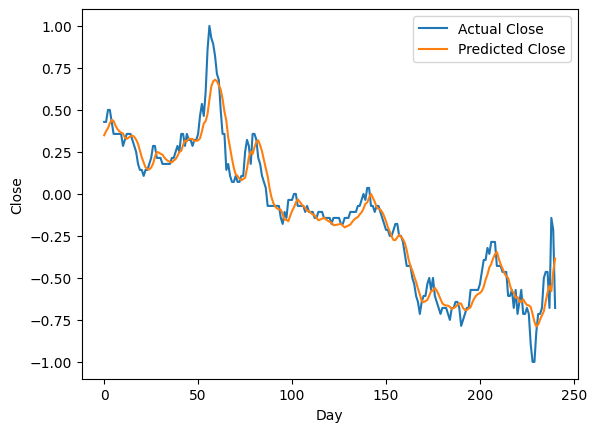

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.291
***************************************************

Epoch: 2

Val Loss: 0.257
***************************************************

Epoch: 3

Val Loss: 0.228
***************************************************

Epoch: 4

Val Loss: 0.191
***************************************************

Epoch: 5

Val Loss: 0.163
***************************************************

Epoch: 6

Val Loss: 0.139
***************************************************

Epoch: 7

Val Loss: 0.124
***************************************************

Epoch: 8

Val Loss: 0.102
***************************************************

Epoch: 9

Val Loss: 0.092
***************************************************

Epoch: 10

Val Loss: 0.085
***************************************************

Epoch: 11

Val Loss: 0.083
**********************************

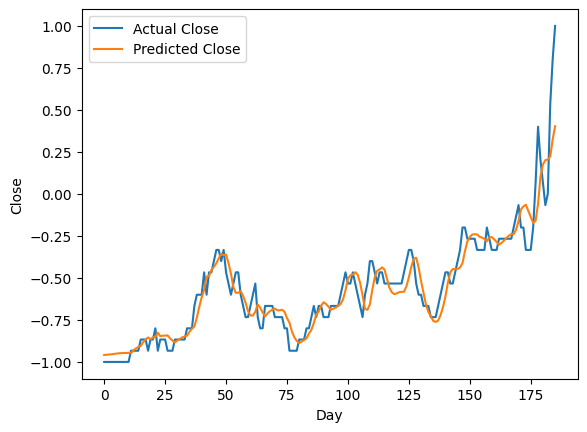

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.810
***************************************************

Epoch: 2

Val Loss: 0.694
***************************************************

Epoch: 3

Val Loss: 0.690
***************************************************

Epoch: 4

Val Loss: 0.603
***************************************************

Epoch: 5

Val Loss: 0.539
***************************************************

Epoch: 6

Val Loss: 0.510
***************************************************

Epoch: 7

Val Loss: 0.418
***************************************************

Epoch: 8

Val Loss: 0.381
***************************************************

Epoch: 9

Val Loss: 0.352
***************************************************

Epoch: 10

Val Loss: 0.281
***************************************************

Epoch: 11

Val Loss: 0.222
**********************************

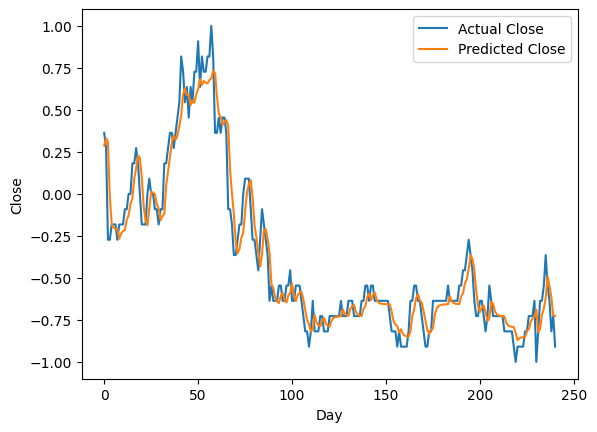

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.311
***************************************************

Epoch: 2

Val Loss: 0.289
***************************************************

Epoch: 3

Val Loss: 0.270
***************************************************

Epoch: 4

Val Loss: 0.245
***************************************************

Epoch: 5

Val Loss: 0.226
***************************************************

Epoch: 6

Val Loss: 0.198
***************************************************

Epoch: 7

Val Loss: 0.157
***************************************************

Epoch: 8

Val Loss: 0.116
***************************************************

Epoch: 9

Val Loss: 0.079
***************************************************

Epoch: 10

Val Loss: 0.048
***************************************************

Epoch: 11

Val Loss: 0.031
**********************************

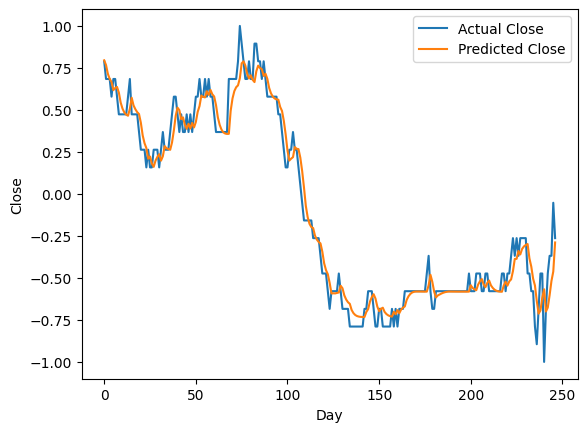

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.342
***************************************************

Epoch: 2

Val Loss: 0.317
***************************************************

Epoch: 3

Val Loss: 0.291
***************************************************

Epoch: 4

Val Loss: 0.261
***************************************************

Epoch: 5

Val Loss: 0.229
***************************************************

Epoch: 6

Val Loss: 0.193
***************************************************

Epoch: 7

Val Loss: 0.162
***************************************************

Epoch: 8

Val Loss: 0.135
***************************************************

Epoch: 9

Val Loss: 0.108
***************************************************

Epoch: 10

Val Loss: 0.080
***************************************************

Epoch: 11

Val Loss: 0.057
**********************************

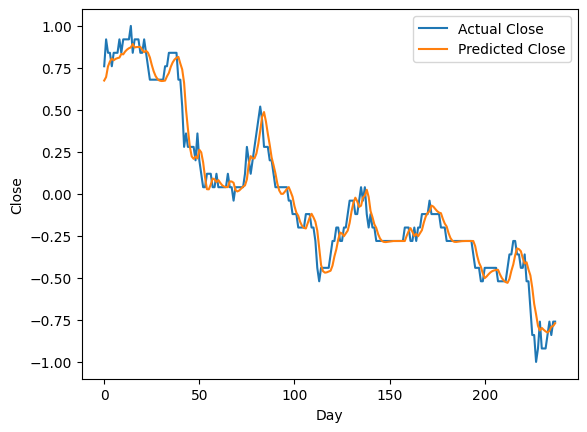

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.296
***************************************************

Epoch: 2

Val Loss: 0.276
***************************************************

Epoch: 3

Val Loss: 0.252
***************************************************

Epoch: 4

Val Loss: 0.207
***************************************************

Epoch: 5

Val Loss: 0.183
***************************************************

Epoch: 6

Val Loss: 0.141
***************************************************

Epoch: 7

Val Loss: 0.121
***************************************************

Epoch: 8

Val Loss: 0.125
***************************************************

Epoch: 9

Val Loss: 0.087
***************************************************

Epoch: 10

Val Loss: 0.079
***************************************************

Epoch: 11

Val Loss: 0.076
**********************************

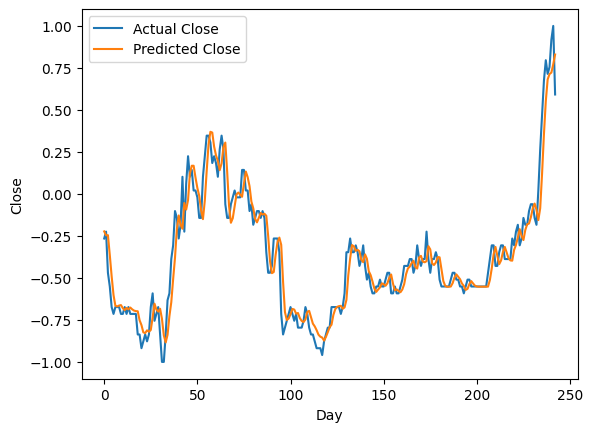

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.371
***************************************************

Epoch: 2

Val Loss: 0.336
***************************************************

Epoch: 3

Val Loss: 0.293
***************************************************

Epoch: 4

Val Loss: 0.252
***************************************************

Epoch: 5

Val Loss: 0.214
***************************************************

Epoch: 6

Val Loss: 0.175
***************************************************

Epoch: 7

Val Loss: 0.147
***************************************************

Epoch: 8

Val Loss: 0.122
***************************************************

Epoch: 9

Val Loss: 0.107
***************************************************

Epoch: 10

Val Loss: 0.094
***************************************************

Epoch: 11

Val Loss: 0.086
**********************************

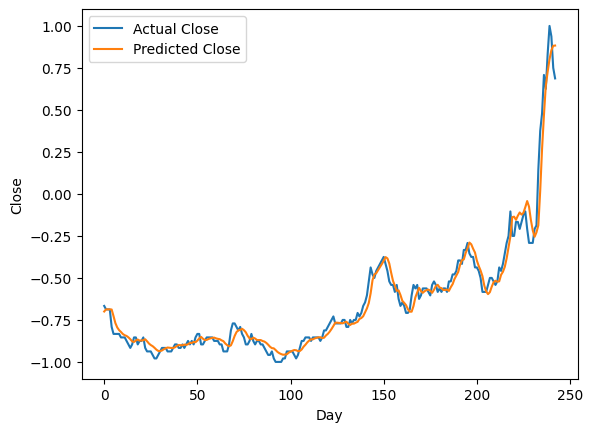

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.166
***************************************************

Epoch: 2

Val Loss: 0.124
***************************************************

Epoch: 3

Val Loss: 0.079
***************************************************

Epoch: 4

Val Loss: 0.057
***************************************************

Epoch: 5

Val Loss: 0.046
***************************************************

Epoch: 6

Val Loss: 0.034
***************************************************

Epoch: 7

Val Loss: 0.032
***************************************************

Epoch: 8

Val Loss: 0.033
***************************************************

Epoch: 9

Val Loss: 0.031
***************************************************

Epoch: 10

Val Loss: 0.030
***************************************************

Epoch: 11

Val Loss: 0.031
**********************************

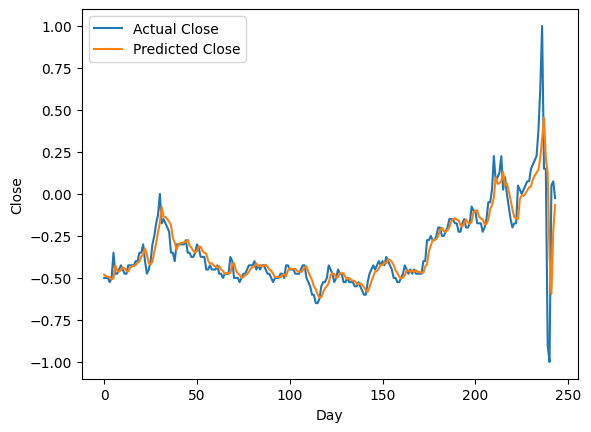

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.592
***************************************************

Epoch: 2

Val Loss: 0.575
***************************************************

Epoch: 3

Val Loss: 0.425
***************************************************

Epoch: 4

Val Loss: 0.372
***************************************************

Epoch: 5

Val Loss: 0.321
***************************************************

Epoch: 6

Val Loss: 0.257
***************************************************

Epoch: 7

Val Loss: 0.177
***************************************************

Epoch: 8

Val Loss: 0.142
***************************************************

Epoch: 9

Val Loss: 0.115
***************************************************

Epoch: 10

Val Loss: 0.099
***************************************************

Epoch: 11

Val Loss: 0.088
**********************************

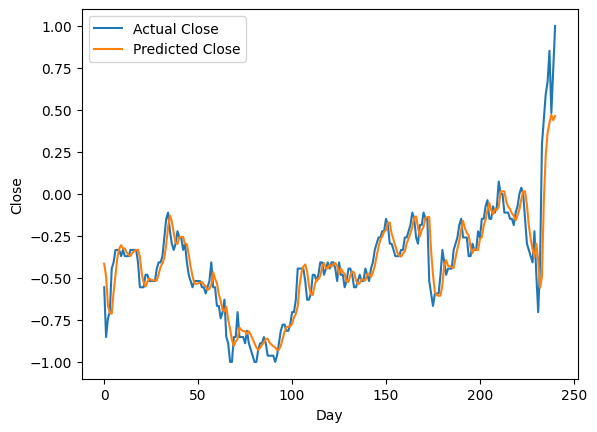

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.439
***************************************************

Epoch: 2

Val Loss: 0.322
***************************************************

Epoch: 3

Val Loss: 0.287
***************************************************

Epoch: 4

Val Loss: 0.228
***************************************************

Epoch: 5

Val Loss: 0.226
***************************************************

Epoch: 6

Val Loss: 0.179
***************************************************

Epoch: 7

Val Loss: 0.157
***************************************************

Epoch: 8

Val Loss: 0.120
***************************************************

Epoch: 9

Val Loss: 0.119
***************************************************

Epoch: 10

Val Loss: 0.081
***************************************************

Epoch: 11

Val Loss: 0.069
**********************************

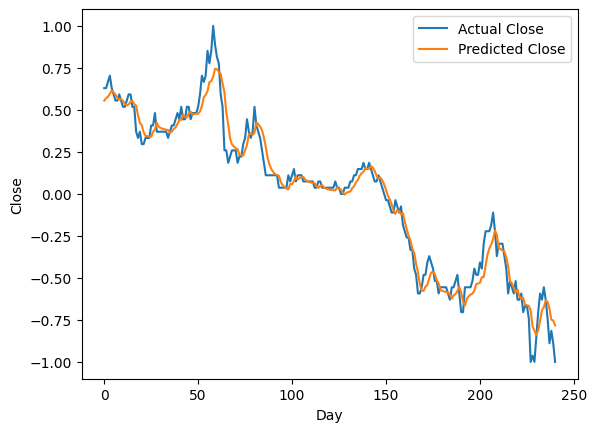

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.825
***************************************************

Epoch: 2

Val Loss: 0.751
***************************************************

Epoch: 3

Val Loss: 0.666
***************************************************

Epoch: 4

Val Loss: 0.594
***************************************************

Epoch: 5

Val Loss: 0.515
***************************************************

Epoch: 6

Val Loss: 0.422
***************************************************

Epoch: 7

Val Loss: 0.334
***************************************************

Epoch: 8

Val Loss: 0.255
***************************************************

Epoch: 9

Val Loss: 0.182
***************************************************

Epoch: 10

Val Loss: 0.127
***************************************************

Epoch: 11

Val Loss: 0.096
**********************************

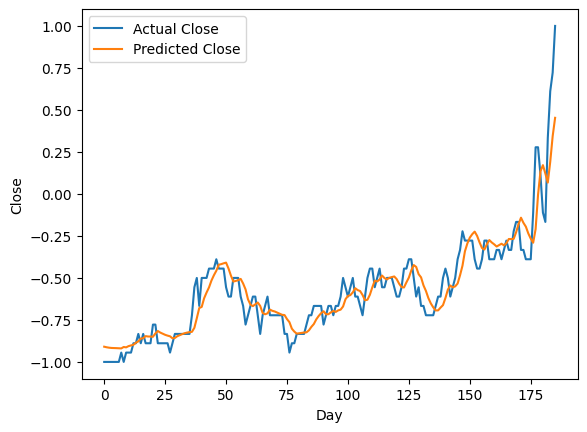

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 1.116
***************************************************

Epoch: 2

Val Loss: 0.962
***************************************************

Epoch: 3

Val Loss: 0.905
***************************************************

Epoch: 4

Val Loss: 0.837
***************************************************

Epoch: 5

Val Loss: 0.694
***************************************************

Epoch: 6

Val Loss: 0.601
***************************************************

Epoch: 7

Val Loss: 0.578
***************************************************

Epoch: 8

Val Loss: 0.459
***************************************************

Epoch: 9

Val Loss: 0.426
***************************************************

Epoch: 10

Val Loss: 0.366
***************************************************

Epoch: 11

Val Loss: 0.303
**********************************

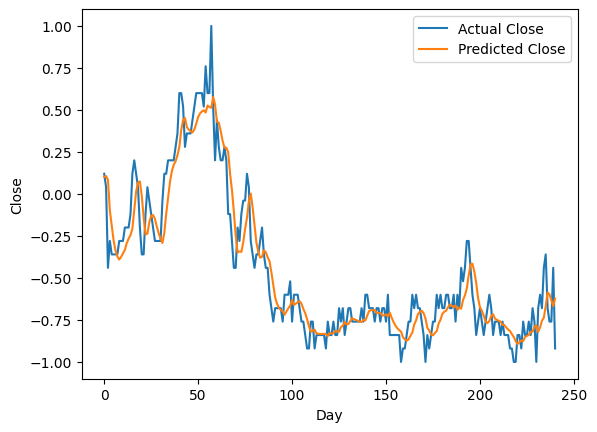

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.302
***************************************************

Epoch: 2

Val Loss: 0.286
***************************************************

Epoch: 3

Val Loss: 0.257
***************************************************

Epoch: 4

Val Loss: 0.237
***************************************************

Epoch: 5

Val Loss: 0.207
***************************************************

Epoch: 6

Val Loss: 0.178
***************************************************

Epoch: 7

Val Loss: 0.150
***************************************************

Epoch: 8

Val Loss: 0.119
***************************************************

Epoch: 9

Val Loss: 0.090
***************************************************

Epoch: 10

Val Loss: 0.067
***************************************************

Epoch: 11

Val Loss: 0.049
**********************************

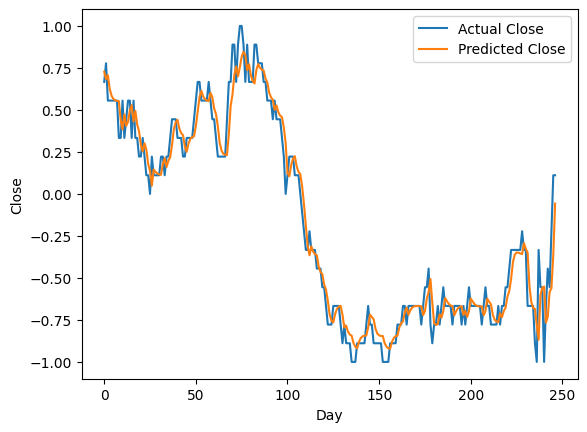

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.400
***************************************************

Epoch: 2

Val Loss: 0.355
***************************************************

Epoch: 3

Val Loss: 0.317
***************************************************

Epoch: 4

Val Loss: 0.285
***************************************************

Epoch: 5

Val Loss: 0.257
***************************************************

Epoch: 6

Val Loss: 0.229
***************************************************

Epoch: 7

Val Loss: 0.199
***************************************************

Epoch: 8

Val Loss: 0.170
***************************************************

Epoch: 9

Val Loss: 0.140
***************************************************

Epoch: 10

Val Loss: 0.112
***************************************************

Epoch: 11

Val Loss: 0.087
**********************************

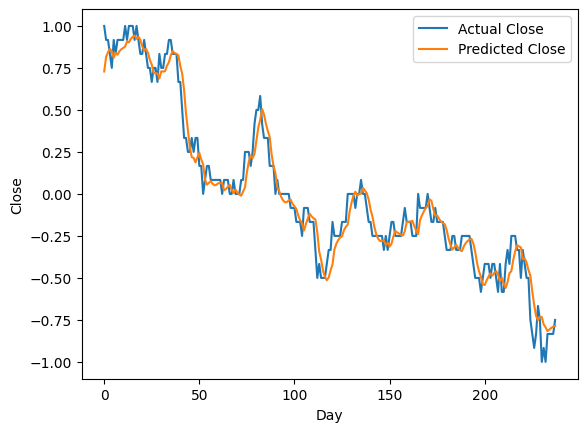

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.191
***************************************************

Epoch: 2

Val Loss: 0.172
***************************************************

Epoch: 3

Val Loss: 0.152
***************************************************

Epoch: 4

Val Loss: 0.142
***************************************************

Epoch: 5

Val Loss: 0.130
***************************************************

Epoch: 6

Val Loss: 0.125
***************************************************

Epoch: 7

Val Loss: 0.118
***************************************************

Epoch: 8

Val Loss: 0.115
***************************************************

Epoch: 9

Val Loss: 0.111
***************************************************

Epoch: 10

Val Loss: 0.108
***************************************************

Epoch: 11

Val Loss: 0.109
**********************************

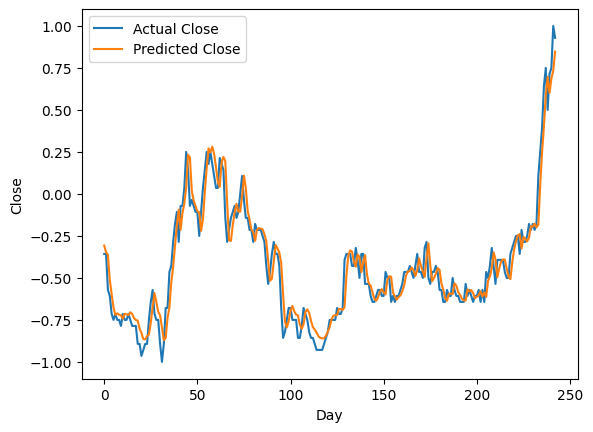

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.146
***************************************************

Epoch: 2

Val Loss: 0.123
***************************************************

Epoch: 3

Val Loss: 0.138
***************************************************

Epoch: 4

Val Loss: 0.106
***************************************************

Epoch: 5

Val Loss: 0.102
***************************************************

Epoch: 6

Val Loss: 0.099
***************************************************

Epoch: 7

Val Loss: 0.095
***************************************************

Epoch: 8

Val Loss: 0.090
***************************************************

Epoch: 9

Val Loss: 0.085
***************************************************

Epoch: 10

Val Loss: 0.085
***************************************************

Epoch: 11

Val Loss: 0.075
**********************************

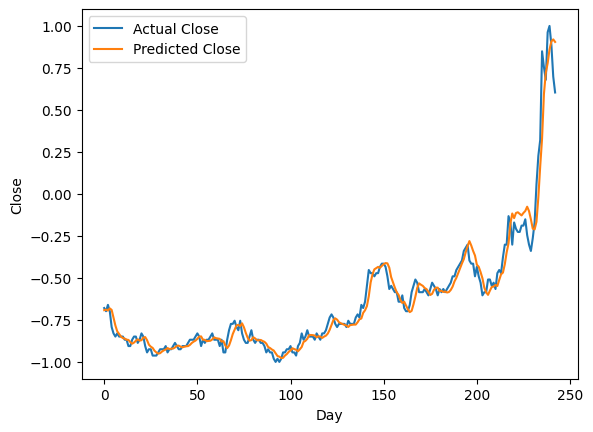

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.872
***************************************************

Epoch: 2

Val Loss: 0.785
***************************************************

Epoch: 3

Val Loss: 0.696
***************************************************

Epoch: 4

Val Loss: 0.617
***************************************************

Epoch: 5

Val Loss: 0.532
***************************************************

Epoch: 6

Val Loss: 0.439
***************************************************

Epoch: 7

Val Loss: 0.351
***************************************************

Epoch: 8

Val Loss: 0.250
***************************************************

Epoch: 9

Val Loss: 0.162
***************************************************

Epoch: 10

Val Loss: 0.092
***************************************************

Epoch: 11

Val Loss: 0.055
**********************************

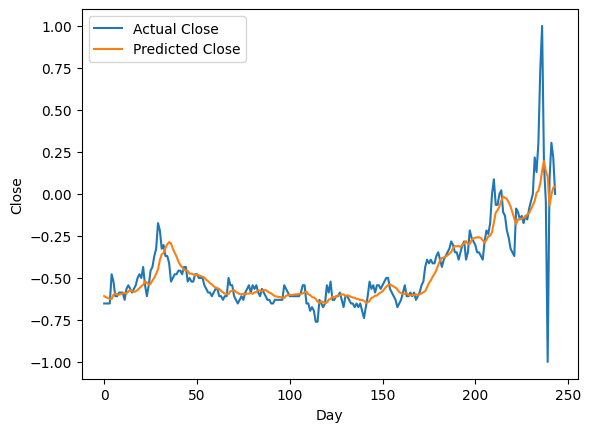

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.299
***************************************************

Epoch: 2

Val Loss: 0.252
***************************************************

Epoch: 3

Val Loss: 0.205
***************************************************

Epoch: 4

Val Loss: 0.157
***************************************************

Epoch: 5

Val Loss: 0.113
***************************************************

Epoch: 6

Val Loss: 0.081
***************************************************

Epoch: 7

Val Loss: 0.059
***************************************************

Epoch: 8

Val Loss: 0.050
***************************************************

Epoch: 9

Val Loss: 0.046
***************************************************

Epoch: 10

Val Loss: 0.045
***************************************************

Epoch: 11

Val Loss: 0.042
**********************************

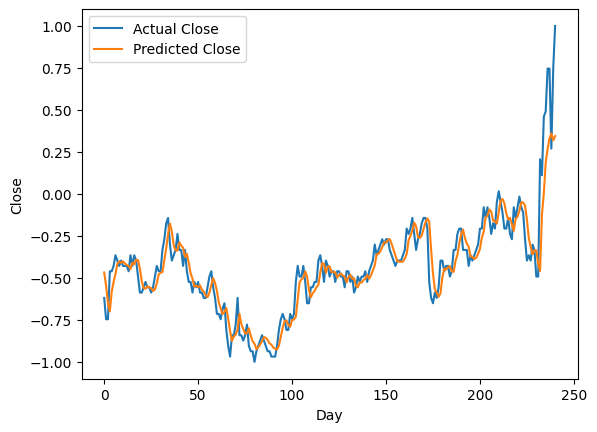

torch.Size([16, 10, 1]) torch.Size([16, 1])
LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)
Epoch: 1

Val Loss: 0.339
***************************************************

Epoch: 2

Val Loss: 0.305
***************************************************

Epoch: 3

Val Loss: 0.249
***************************************************

Epoch: 4

Val Loss: 0.224
***************************************************

Epoch: 5

Val Loss: 0.239
***************************************************

Epoch: 6

Val Loss: 0.198
***************************************************

Epoch: 7

Val Loss: 0.191
***************************************************

Epoch: 8

Val Loss: 0.212
***************************************************

Epoch: 9

Val Loss: 0.188
***************************************************

Epoch: 10

Val Loss: 0.175
***************************************************

Epoch: 11

Val Loss: 0.181
**********************************

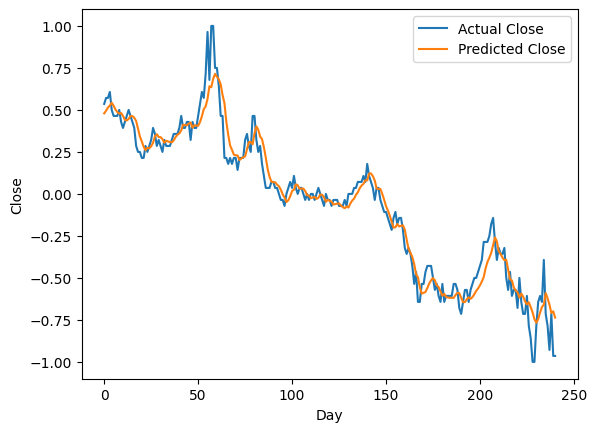

In [5]:
tag_list = ['Open','High','Low','Close']
for tag_name in tag_list:
    for file in files[:-1]:  # Exclude the current year's data for training
        # Load and preprocess data
        data = pd.read_csv(file)
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.rename(columns={tag_name :'Price'})
        data = data[['Date', 'Price']]
        # plt.plot(data['Date'], data['Price'])
        # plt.show()  # Show the plot for each file

        # Prepare the data for training
        def prepare_dataframe_for_lstm(df, n_steps):
            df = dc(df)

            df.set_index('Date', inplace=True)

            for i in range(1, n_steps+1):
                df[f'Price(t-{i})'] = df['Price'].shift(i)

            df.dropna(inplace=True)

            return df

        lookback = 10
        shifted_df = prepare_dataframe_for_lstm(data, lookback)

        shifted_df_as_np = shifted_df.to_numpy()
        scaler = MinMaxScaler(feature_range=(-1, 1))
        shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

        X = shifted_df_as_np[:, 1:]
        y = shifted_df_as_np[:, 0]
        X = dc(np.flip(X, axis=1))

        X = X.reshape((-1, lookback, 1))
        y = y.reshape((-1, 1))

        X = torch.tensor(X).float()
        y = torch.tensor(y).float()

        train_dataset = TimeSeriesDataset(X, y)
        
        batch_size = 16
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for _, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            print(x_batch.shape, y_batch.shape)
            break

        model = LSTM(1, 4, 1)
        model.to(device)
        print(model)

        learning_rate = 0.001
        num_epochs = 100
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            train_one_epoch(train_loader, model, optimizer, loss_function, epoch)
            validate_one_epoch(train_loader, model, loss_function)
        save_path = f'/workspaces/Futures-First/Prediction/LSTM/test/{tag_name}/'
        os.makedirs(save_path, exist_ok=True)

        torch.save(model.state_dict(), os.path.join(save_path, f'lstm_model_{file.split("/")[-1].split(".")[0]}.pt'))
        with torch.no_grad():
            predicted = model(X.to(device)).to('cpu').numpy()

        plt.plot(y, label='Actual Close')
        plt.plot(predicted, label='Predicted Close')
        plt.xlabel('Day')
        plt.ylabel('Close')
        plt.legend()
        plt.show()

In [6]:
df = pd.read_csv(files[-1])
last_row = df[['Open', 'High', 'Low', 'Close']].iloc[-1]

ohlc = {
    'Open': [last_row['Open']],
    'High': [last_row['High']],
    'Low': [last_row['Low']],
    'Close': [last_row['Close']]
}

print(ohlc)

{'Open': [-11.0], 'High': [-10.75], 'Low': [-11.25], 'Close': [-11.0]}


In [7]:
for tag_name in tag_list:
    # Function to prepare data for LSTM
    def prepare_dataframe_for_lstm(df, n_steps):
        df = dc(df)
        df.set_index('Date', inplace=True)
        for i in range(1, n_steps+1):
            df[f'Price(t-{i})'] = df['Price'].shift(i)
        df.dropna(inplace=True)
        return df

    # Load and prepare the data
    data = pd.read_csv(files[-1])
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.rename(columns={tag_name:'Price'})
    data = data[['Date', 'Price']]

    lookback = 10
    shifted_df = prepare_dataframe_for_lstm(data, lookback)

    shifted_df_as_np = shifted_df.to_numpy()
    scaler = MinMaxScaler(feature_range=(-1, 1))
    shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    X = dc(np.flip(X, axis=1))

    X = X.reshape((-1, lookback, 1))
    y = y.reshape((-1, 1))

    X_test = torch.tensor(X).float()
    y_test = torch.tensor(y).float()

    # Load the trained model
    model_file = '/workspaces/Futures-First/Prediction/LSTM/test/'+tag_name+'/lstm_model_'+files[-2][-8:-4]+'.pt'
    model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    # Predict the last part of the dataset
    test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

    # Inverse transform the predictions
    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = test_predictions
    dummies = scaler.inverse_transform(dummies)
    test_predictions = dc(dummies[:, 0])

    dummies = np.zeros((X_test.shape[0], lookback+1))
    dummies[:, 0] = y_test.flatten()
    dummies = scaler.inverse_transform(dummies)
    new_y_test = dc(dummies[:, 0])

    # Prepare for predicting future prices
    last_window = X_test[-1].cpu().numpy()

    future_predictions = []

    # Predict the next 5 days
    for _ in range(10):
        # Predict the next price
        pred = model(torch.tensor(last_window).unsqueeze(0).float().to(device)).detach().cpu().numpy().flatten()[0]
        
        # Scale back to original price
        dummies = np.zeros((1, lookback + 1))
        dummies[:, 0] = pred
        dummies = scaler.inverse_transform(dummies)
        
        pred_original = dummies[:, 0][0]
        future_predictions.append(pred_original)
        
        # Update the window for the next prediction
        last_window = np.roll(last_window, -1)
        last_window[-1, 0] = pred

    # Combine all predictions
    all_predictions = np.concatenate((test_predictions, np.array(future_predictions)))

    # Create plotly figure
    fig = go.Figure()

    # Add traces for actual and predicted values
    fig.add_trace(go.Scatter(
        x=np.arange(len(new_y_test)),
        y=new_y_test,
        mode='lines',
        name='Actual Close'
    ))

    fig.add_trace(go.Scatter(
        x=np.arange(len(test_predictions)),
        y=test_predictions,
        mode='lines',
        name='Predicted Close (Past)'
    ))

    fig.add_trace(go.Scatter(
        x=np.arange(len(test_predictions), len(all_predictions)),
        y=future_predictions,
        mode='lines',
        name='Predicted Close (Future)',
        # line=dict(dash='dash')
    ))

    # Update layout
    fig.update_layout(
        title="Futures Price Prediction of "+tag_name,
        xaxis_title="Day",
        yaxis_title="Price",
        legend_title="Legend"
    )

    # Show plot
    fig.show()
    # future_num = [f"{number:.4f}" for number in future_predictions]
    ohlc[tag_name].extend(future_predictions[:4])

/tmp/ipykernel_37544/1832186338.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


/tmp/ipykernel_37544/1832186338.py:37: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



/tmp/ipykernel_37544/1832186338.py:37: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



/tmp/ipykernel_37544/1832186338.py:37: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [8]:
candle = go.Candlestick(
    x=['T-1_real','T-1','T','T+1'],  
    open=ohlc['Open'],
    high=ohlc['High'],
    low=ohlc['Low'],
    close=ohlc['Close']
)

# Create a figure and add the candlestick
fig = go.Figure(data=[candle])

# Update layout to show titles
fig.update_layout(title='Candlesticks for '+files[-1][-19:-9], xaxis_title='Date', yaxis_title='Price')

# Show the figure
fig.show()